<h1>Dog Project Work Book</h1>

#### Brief Overview of Work Book

This workbook outlines the process of training a dog breed classifier for Udacity's Dog Breed Classifier project in the AI Nanodegree program.

The things I tried out include:
<ol>
<li>
<p>I used a data generator rather than loading in all the data. Because of this I was able to test out data augmentation relatively easily. I was also able to implement a preprocessing function and integrate it into the data generation. Additionally, I was able to adjust the image size easily, which had a noticable effect in improving the models.
</p>
        
<p>Ultimately, data augmentation did not improve the models very much while increase the time to train the models. Although, when training a model from scratch it did show a benefit.
</p>
</li>
<li>
I tried out multiple pretrained models, using the conv layers to generate the bottleneck features of the data. Then trained a small classifier on top of each of those. I also tried to finetune the vgg19 network, but it didn't noticably improve the accuracy. Ultimately, the Inception based models performed the best, acheiving around 90% on the validation sets.
</li>
<li>
Once I had several models performing well I organized them into an ensemble, averaging their predictions. This was able to produce a 93.6% accuracy on the test dataset.
</li>
<li>
Finally, at the end of the notebook I have a short insight into the error the models ran into and also some visualization of what the model is seeing when it looks at an image. This section could be organized into a more detailed analysis which I may or may not do in the future.
</li>
</ol>

#### Import Statements

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image                  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.datasets import load_files
from sklearn.utils import shuffle
import numpy as np
from glob import glob
import random
import matplotlib.pyplot as plt                        
%matplotlib inline

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint  

Using TensorFlow backend.


# Organize the Data

In [6]:
# Data file locations
train_data_path = 'dogImages/train/'
valid_data_path = 'dogImages/valid/'
test_data_path = 'dogImages/test/'

## Data Augmentation

### Augmentation and Preprocessing for Models

The pretrained models that will be used were trained on images processed in two different ways. ResNet and VGG models expect images to be centered around zero and have BGR color channel order so below is a preprocessing function that can be applied to the data generator. This will apply the preprocessing to the image as it is input into the model. 

The Inception based model seem to perform best when the image values are normalized to be between 0 and 1 so each image is divided by 255 as it is input into the model.

In [8]:
def imagenet_prep(image_tensor):
    '''
        Takes the image tensors for one image. Applies the preprocessing need for the Resnet and VGG models.
        
        Inputs: Image tensor of shape (width, height, colorchannels)
        
        Returns: Tensor of same shape with color channels flipped and values centered around zero for each color channel.
    '''
    # imagenet averages for RGB
    image_net_mean = np.array([103.939,116.779,123.68])
    image_tensor -= image_net_mean
    
    # Flip color channels
    image_tensor = image_tensor[:, :, ::-1]
    return image_tensor

In [9]:
batch_size = 32

# Augments the data for the Inception models
inception_generator_da = ImageDataGenerator(rescale=1/255,
                                                  rotation_range=10.0,
                                                  width_shift_range=0.1,
                                                  height_shift_range=0.1,
                                                  shear_range=0.05,
                                                  zoom_range=0.1,
                                                  horizontal_flip=True,
                                                  vertical_flip=False,
                                                  fill_mode="reflect")

# prepares data for the Inception models without augmenting the data
inception_generator = ImageDataGenerator(rescale=1/255)


# Augments the data for the ResNet and VGG models
resvgg_generator_da = ImageDataGenerator(preprocessing_function=imagenet_prep,
                                               rescale=1.,
                                               rotation_range=10.0,
                                               width_shift_range=0.1,
                                               height_shift_range=0.1,
                                               shear_range=0.05,
                                               zoom_range=0.1,
                                               horizontal_flip=True,
                                               vertical_flip=False,
                                               fill_mode="reflect")

# prepares data for the ResNet and VGG models without augmenting the data
resvgg_generator = ImageDataGenerator(preprocessing_function=imagenet_prep)


### Data Generators

Here are the generators for the data. There are a few things to note:
<ol>
    <li>The target image size is 350x350px. The larger image size produces a better accuracy compared to say 224x224px or 299x299px which is standard for VGG and Inception respectively. One possible explaination of this is that to the model you are zooming in on the image which may make it easier to pick up details.</li>
    <li>Shuffle is set to False. This is done because we will be passing the data from these generators through the conv layers of the pretrained models in order to obtain the bottle neck features. The data needs to stay in synch with the labels so to shuffle the data, it needs to be done with the bottleneck features and the labels. A step outline below.
</ol>

In [10]:
inception_train_data = inception_generator.flow_from_directory(train_data_path,
                                                       target_size=(350, 350),
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       class_mode='categorical')

inception_valid_data = inception_generator.flow_from_directory(valid_data_path,
                                                           target_size=(350, 350),
                                                           batch_size=batch_size,
                                                           shuffle=False,
                                                           class_mode='categorical')

resvgg_train_data = resvgg_generator.flow_from_directory(train_data_path,
                                                       target_size=(350, 350),
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       class_mode='categorical')

resvgg_valid_data = resvgg_generator.flow_from_directory(valid_data_path,
                                                           target_size=(350, 350),
                                                           batch_size=batch_size,
                                                           shuffle=False,
                                                           class_mode='categorical')

train_samples = len(inception_train_data.filenames)
validation_samples = len(inception_valid_data.filenames)
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [11]:
# Labels will be the same for both types of models; needed to match back to bottleneck features
train_labels = to_categorical(inception_train_data.classes)
valid_labels = to_categorical(inception_valid_data.classes)

# Breed Classifier for Dogs

## CNN from Scratch

Building a CNN from scratch we can make a generator that does shuffle the data because we won't be computing any bottleneck features.

### Data Generator

In [39]:
scratch_train_data = inception_generator_da.flow_from_directory(train_data_path,
                                                       target_size=(350, 350),
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       class_mode='categorical')

scratch_valid_data = inception_generator.flow_from_directory(valid_data_path,
                                                           target_size=(350, 350),
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           class_mode='categorical')

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


### Build Model

The architechture is based off the VGG architechture, but with just 1 conv layer for each block.

In [40]:
model = Sequential()
# Conv layer1
model.add(Conv2D(32, 3, strides=(1,1), padding='same', activation='relu', input_shape=(350,350,3)))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer2
model.add(Conv2D(64, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer3
model.add(Conv2D(128, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer4
model.add(Conv2D(256, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer5
model.add(Conv2D(256, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

#Flatten Layer
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

#Fully Connected Layer 2
model.add(Dense(133, activation='softmax'))

In [41]:
model.load_weights(filepath='saved_models/weights.best.from_scratch_da.hdf5')

In [42]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

### Train Model

After training it for several cycles(5 I think) of 10 epochs the model get to about 50% accuracy which is pretty good since there are 133 classes and only 6680 training examples.

Pure guessing would only be 00.75%.

In [47]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_da.hdf5', 
                               verbose=0, save_best_only=True)

model.fit_generator(scratch_train_data, steps_per_epoch=(1+train_samples//batch_size), epochs=10,
                    callbacks=[checkpointer], verbose=2, 
                    validation_data=scratch_valid_data,
                    validation_steps=(1+validation_samples//batch_size))

Epoch 1/10
 - 218s - loss: 0.2442 - acc: 0.9242 - val_loss: 2.9442 - val_acc: 0.4766
Epoch 2/10
 - 214s - loss: 0.2494 - acc: 0.9245 - val_loss: 2.7488 - val_acc: 0.4778
Epoch 3/10
 - 206s - loss: 0.2488 - acc: 0.9224 - val_loss: 2.7818 - val_acc: 0.4743
Epoch 4/10
 - 209s - loss: 0.2389 - acc: 0.9243 - val_loss: 2.7629 - val_acc: 0.4754
Epoch 5/10
 - 202s - loss: 0.2670 - acc: 0.9183 - val_loss: 3.2061 - val_acc: 0.4778
Epoch 6/10
 - 211s - loss: 0.2631 - acc: 0.9129 - val_loss: 2.9207 - val_acc: 0.4778
Epoch 7/10
 - 216s - loss: 0.2320 - acc: 0.9223 - val_loss: 2.6750 - val_acc: 0.4778
Epoch 8/10
 - 223s - loss: 0.2335 - acc: 0.9244 - val_loss: 3.2669 - val_acc: 0.4443
Epoch 9/10
 - 218s - loss: 0.2186 - acc: 0.9285 - val_loss: 2.9923 - val_acc: 0.4850
Epoch 10/10
 - 205s - loss: 0.2538 - acc: 0.9219 - val_loss: 2.6119 - val_acc: 0.4958


## Build Classifiers Using Pretrained Models

The same process will be used for 6 different models and follows these steps:
    <ol>
    <li>Import and load the conv layers of the pretrained model.</li>
    <li>Compute the bottleneck features by using the pretrained model to predict on the data generater.</li>
    <li>Shuffle the bottleneck features and labels corresponding features and labels stay paired.</li>
    <li>Construct the model that will go ontop of the pretrained conv layers.</li>
    <li>Train the model with the bottleneck features and labels, saving the weights.</li>
    </ol>

### Inception Model

In [12]:
from keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(include_top=False, weights='imagenet')

In [9]:
inception_bottleneck = inception.predict_generator(inception_train_data, steps=1)
inception_valid = inception.predict_generator(inception_valid_data, steps=1)

In [10]:
shuf_train, shuf_train_labels = shuffle(inception_bottleneck, train_labels)
shuf_val, shuf_val_labels = shuffle(inception_valid, valid_labels)

In [13]:
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=(9,9,2048)))
inception_model.add(BatchNormalization())

inception_model.add(Dense(133, activation='softmax'))
inception_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception6.hdf5', 
                               verbose=0, save_best_only=True)

In [32]:
inception_model.fit(shuf_train, shuf_train_labels, 
                        validation_data=(shuf_val, shuf_val_labels),
                        epochs=10, batch_size=32, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
 - 7s - loss: 0.9024 - acc: 0.7671 - val_loss: 0.6431 - val_acc: 0.8599
Epoch 2/10
 - 6s - loss: 0.2002 - acc: 0.9346 - val_loss: 0.3820 - val_acc: 0.8814
Epoch 3/10
 - 6s - loss: 0.0947 - acc: 0.9714 - val_loss: 0.3923 - val_acc: 0.8970
Epoch 4/10
 - 6s - loss: 0.0552 - acc: 0.9847 - val_loss: 0.3996 - val_acc: 0.8970
Epoch 5/10
 - 7s - loss: 0.0322 - acc: 0.9925 - val_loss: 0.3705 - val_acc: 0.8994
Epoch 6/10
 - 6s - loss: 0.0233 - acc: 0.9955 - val_loss: 0.3947 - val_acc: 0.9078
Epoch 7/10
 - 6s - loss: 0.0239 - acc: 0.9951 - val_loss: 0.3784 - val_acc: 0.9102
Epoch 8/10
 - 6s - loss: 0.0207 - acc: 0.9952 - val_loss: 0.4408 - val_acc: 0.8862
Epoch 9/10
 - 6s - loss: 0.0206 - acc: 0.9964 - val_loss: 0.4234 - val_acc: 0.9006
Epoch 10/10
 - 6s - loss: 0.0209 - acc: 0.9942 - val_loss: 0.4817 - val_acc: 0.8898


### VGG16 Model

In [9]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, weights='imagenet')

In [64]:
vgg16_bottleneck = vgg16.predict_generator(resvgg_train_data, steps=1)
vgg16_valid = vgg16.predict_generator(resvgg_valid_data, steps=1)

In [65]:
shuf_train, shuf_train_labels = shuffle(vgg16_bottleneck, train_labels)
shuf_val, shuf_val_labels = shuffle(vgg16_valid, valid_labels)

In [10]:
vgg16_model = Sequential()
vgg16_model.add(GlobalAveragePooling2D(input_shape=(None, None, 512)))
vgg16_model.add(BatchNormalization())

vgg16_model.add(Dense(133, activation='softmax'))
vgg16_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg16.hdf5', 
                               verbose=0, save_best_only=True)

In [69]:
vgg16_model.fit(shuf_train, shuf_train_labels, 
                        validation_data=(shuf_val, shuf_val_labels),
                        epochs=10, batch_size=32, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
 - 3s - loss: 0.0647 - acc: 0.9952 - val_loss: 0.6923 - val_acc: 0.8000
Epoch 2/10
 - 4s - loss: 0.0521 - acc: 0.9954 - val_loss: 0.6716 - val_acc: 0.8000
Epoch 3/10
 - 3s - loss: 0.0461 - acc: 0.9973 - val_loss: 0.6840 - val_acc: 0.7892
Epoch 4/10
 - 3s - loss: 0.0392 - acc: 0.9970 - val_loss: 0.6905 - val_acc: 0.7952
Epoch 5/10
 - 3s - loss: 0.0342 - acc: 0.9972 - val_loss: 0.7044 - val_acc: 0.7976
Epoch 6/10
 - 3s - loss: 0.0310 - acc: 0.9976 - val_loss: 0.6888 - val_acc: 0.7976
Epoch 7/10
 - 3s - loss: 0.0290 - acc: 0.9981 - val_loss: 0.7023 - val_acc: 0.7988
Epoch 8/10
 - 3s - loss: 0.0245 - acc: 0.9984 - val_loss: 0.7132 - val_acc: 0.7964
Epoch 9/10
 - 3s - loss: 0.0246 - acc: 0.9972 - val_loss: 0.7263 - val_acc: 0.8024
Epoch 10/10
 - 3s - loss: 0.0235 - acc: 0.9978 - val_loss: 0.7079 - val_acc: 0.7988


### VGG19 Model

In [31]:
from keras.applications.vgg19 import VGG19
vgg19 = VGG19(include_top=False, weights='imagenet')

In [85]:
vgg19_bottleneck = vgg19.predict_generator(resvgg_train_data, steps=1)
vgg19_valid = vgg19.predict_generator(resvgg_valid_data, steps=1)

In [86]:
shuf_train, shuf_train_labels = shuffle(vgg19_bottleneck, train_labels)
shuf_val, shuf_val_labels = shuffle(vgg19_valid, valid_labels)

In [12]:
vgg19_model = Sequential()
vgg19_model.add(GlobalAveragePooling2D(input_shape=(None, None, 512)))
vgg19_model.add(BatchNormalization())

vgg19_model.add(Dense(133, activation='softmax'))
vgg19_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg19.hdf5', 
                               verbose=0, save_best_only=True)

In [90]:
vgg19_model.fit(shuf_train, shuf_train_labels, 
                        validation_data=(shuf_val, shuf_val_labels),
                        epochs=10, batch_size=32, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
 - 3s - loss: 0.0581 - acc: 0.9954 - val_loss: 0.7184 - val_acc: 0.7844
Epoch 2/10
 - 3s - loss: 0.0472 - acc: 0.9970 - val_loss: 0.7210 - val_acc: 0.7964
Epoch 3/10
 - 3s - loss: 0.0398 - acc: 0.9978 - val_loss: 0.7322 - val_acc: 0.7880
Epoch 4/10
 - 3s - loss: 0.0402 - acc: 0.9967 - val_loss: 0.7499 - val_acc: 0.7832
Epoch 5/10
 - 3s - loss: 0.0332 - acc: 0.9972 - val_loss: 0.7548 - val_acc: 0.7820
Epoch 6/10
 - 3s - loss: 0.0285 - acc: 0.9981 - val_loss: 0.7546 - val_acc: 0.7868
Epoch 7/10
 - 3s - loss: 0.0232 - acc: 0.9987 - val_loss: 0.7600 - val_acc: 0.7916
Epoch 8/10
 - 3s - loss: 0.0240 - acc: 0.9975 - val_loss: 0.7543 - val_acc: 0.8036
Epoch 9/10
 - 3s - loss: 0.0219 - acc: 0.9976 - val_loss: 0.7726 - val_acc: 0.7952
Epoch 10/10
 - 3s - loss: 0.0213 - acc: 0.9982 - val_loss: 0.7824 - val_acc: 0.7880


### Fine-Tune VGG

Use functional API to fine tune following the process outlined <a href=https://www.kaggle.com/chmaxx/finetune-vgg16-0-97-with-minimal-effort>here.</a> Unfortunately after finetuning the model there is only about a 1% increase in accuracy while drastically increasing the training time.

And further, VGG is the only model we seem to be able to fine tune in Keras. Attempts to fine tune any of the models with Batch Normalization give much lower training accuracy than what has been shown with the current training process. After some investigation this seems to be bug with Keras or at least several people have run into the same problem and no resolution to the issue has been found.

In [20]:
# Keep same architechture as before
x = vgg19.get_layer('block5_pool').output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(133, activation='softmax')(x)

vgg19_finetune = Model(vgg19.input, x)

In [22]:
# Freeze Convolutional layers to train top model first
for layer in vgg19.layers:
    layer.trainable = False

In [23]:
vgg19_finetune.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
finetune_train_data = resvgg_generator_da.flow_from_directory(train_data_path,
                                                       target_size=(350, 350),
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       class_mode='categorical')

finetune_valid_data = resvgg_generator_da.flow_from_directory(valid_data_path,
                                                           target_size=(350, 350),
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           class_mode='categorical')

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [26]:
vgg19_finetune.fit_generator(finetune_train_data, steps_per_epoch=(1+train_samples//batch_size), epochs=10,
                    verbose=2, 
                    validation_data=finetune_valid_data,
                    validation_steps=(1+validation_samples//batch_size))

Epoch 1/10
 - 253s - loss: 0.1324 - acc: 0.9723 - val_loss: 0.7208 - val_acc: 0.7916
Epoch 2/10
 - 252s - loss: 0.1177 - acc: 0.9759 - val_loss: 0.6880 - val_acc: 0.7940
Epoch 3/10
 - 236s - loss: 0.1015 - acc: 0.9776 - val_loss: 0.7105 - val_acc: 0.7964
Epoch 4/10
 - 223s - loss: 0.0929 - acc: 0.9833 - val_loss: 0.7500 - val_acc: 0.7868
Epoch 5/10
 - 229s - loss: 0.0861 - acc: 0.9833 - val_loss: 0.7915 - val_acc: 0.7832
Epoch 6/10
 - 244s - loss: 0.0834 - acc: 0.9821 - val_loss: 0.7618 - val_acc: 0.7832
Epoch 7/10
 - 242s - loss: 0.0731 - acc: 0.9845 - val_loss: 0.7543 - val_acc: 0.7844
Epoch 8/10
 - 224s - loss: 0.0654 - acc: 0.9865 - val_loss: 0.7502 - val_acc: 0.7904
Epoch 9/10
 - 221s - loss: 0.0619 - acc: 0.9885 - val_loss: 0.8143 - val_acc: 0.7653
Epoch 10/10
 - 235s - loss: 0.0652 - acc: 0.9868 - val_loss: 0.7650 - val_acc: 0.7952


In [34]:
layers = vgg19_finetune.layers
layers.index(vgg19_finetune.get_layer('block5_conv1'))

17

In [32]:
for layer in vgg19_finetune.layers[:17]:
    layer.trainable = False
for layer in vgg19_finetune.layers[17:]:
    layer.trainable = True

In [36]:
vgg19_finetune.compile(optimizer=SGD(lr=0.0001, momentum=0.9),  loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg19ft.hdf5', 
                               verbose=0, save_best_only=True)

In [38]:
vgg19_finetune.fit_generator(finetune_train_data, steps_per_epoch=(1+train_samples//batch_size), epochs=10,
                    verbose=2, 
                    validation_data=finetune_valid_data,
                    validation_steps=(1+validation_samples//batch_size))

Epoch 1/10
 - 236s - loss: 0.0524 - acc: 0.9901 - val_loss: 0.7355 - val_acc: 0.7976
Epoch 2/10
 - 232s - loss: 0.0421 - acc: 0.9929 - val_loss: 0.6979 - val_acc: 0.8024
Epoch 3/10
 - 244s - loss: 0.0403 - acc: 0.9922 - val_loss: 0.7089 - val_acc: 0.8024
Epoch 4/10
 - 251s - loss: 0.0373 - acc: 0.9936 - val_loss: 0.7016 - val_acc: 0.8060
Epoch 5/10
 - 245s - loss: 0.0349 - acc: 0.9940 - val_loss: 0.6989 - val_acc: 0.8024
Epoch 6/10
 - 242s - loss: 0.0313 - acc: 0.9945 - val_loss: 0.6767 - val_acc: 0.8216
Epoch 7/10
 - 233s - loss: 0.0312 - acc: 0.9953 - val_loss: 0.6871 - val_acc: 0.8084
Epoch 8/10
 - 254s - loss: 0.0287 - acc: 0.9949 - val_loss: 0.7443 - val_acc: 0.8060
Epoch 9/10
 - 246s - loss: 0.0283 - acc: 0.9955 - val_loss: 0.6948 - val_acc: 0.7928
Epoch 10/10
 - 248s - loss: 0.0284 - acc: 0.9957 - val_loss: 0.6728 - val_acc: 0.8180


### ResNet Model

In [13]:
from keras.applications.resnet50 import ResNet50
resnet = ResNet50(include_top=False, weights='imagenet')

In [73]:
resnet_bottleneck = resnet.predict_generator(resvgg_train_data, steps=1)
resnet_valid = resnet.predict_generator(resvgg_valid_data, steps=1)

In [74]:
shuf_train, shuf_train_labels = shuffle(resnet_bottleneck, train_labels)
shuf_val, shuf_val_labels = shuffle(resnet_valid, valid_labels)

In [14]:
resnet_model = Sequential()
resnet_model.add(GlobalAveragePooling2D(input_shape=(None, None, 2048)))
resnet_model.add(BatchNormalization())

resnet_model.add(Dense(133, activation='softmax'))
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet.hdf5', 
                               verbose=0, save_best_only=True)

In [82]:
resnet_model.fit(shuf_train, shuf_train_labels, 
                        validation_data=(shuf_val, shuf_val_labels),
                        epochs=10, batch_size=32, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
 - 3s - loss: 0.0211 - acc: 0.9978 - val_loss: 0.8427 - val_acc: 0.7796
Epoch 2/10
 - 3s - loss: 0.0158 - acc: 0.9982 - val_loss: 0.8752 - val_acc: 0.7665
Epoch 3/10
 - 3s - loss: 0.0179 - acc: 0.9978 - val_loss: 0.9030 - val_acc: 0.7701
Epoch 4/10
 - 3s - loss: 0.0180 - acc: 0.9979 - val_loss: 0.8756 - val_acc: 0.7796
Epoch 5/10
 - 3s - loss: 0.0121 - acc: 0.9982 - val_loss: 0.8919 - val_acc: 0.7737
Epoch 6/10
 - 3s - loss: 0.0142 - acc: 0.9984 - val_loss: 0.8654 - val_acc: 0.7916
Epoch 7/10
 - 2s - loss: 0.0129 - acc: 0.9987 - val_loss: 0.9034 - val_acc: 0.7760
Epoch 8/10
 - 2s - loss: 0.0218 - acc: 0.9972 - val_loss: 0.8933 - val_acc: 0.7904
Epoch 9/10
 - 2s - loss: 0.0223 - acc: 0.9970 - val_loss: 0.9916 - val_acc: 0.7605
Epoch 10/10
 - 2s - loss: 0.0396 - acc: 0.9906 - val_loss: 1.1564 - val_acc: 0.7449


### Xception Model

In [14]:
from keras.applications.xception import Xception, preprocess_input
xception = Xception(include_top=False, weights='imagenet')

In [83]:
xception_bottleneck = xception.predict_generator(inception_train_data, steps=1)
xception_valid = xception.predict_generator(inception_valid_data, steps=1)

In [84]:
shuf_train, shuf_train_labels = shuffle(xception_bottleneck, train_labels)
shuf_val, shuf_val_labels = shuffle(xception_valid, valid_labels)

In [15]:
xception_model = Sequential()
xception_model.add(GlobalAveragePooling2D(input_shape=(None, None, 2048)))
xception_model.add(BatchNormalization())

xception_model.add(Dense(133, activation='softmax'))
xception_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception.hdf5', 
                               verbose=0, save_best_only=True)

In [112]:
xception_model.fit(shuf_train, shuf_train_labels, 
                        validation_data=(shuf_val, shuf_val_labels),
                        epochs=10, batch_size=32, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
 - 43s - loss: 0.8361 - acc: 0.7840 - val_loss: 1.0529 - val_acc: 0.8659
Epoch 2/10
 - 34s - loss: 0.2171 - acc: 0.9301 - val_loss: 0.3965 - val_acc: 0.8731
Epoch 3/10
 - 30s - loss: 0.1255 - acc: 0.9581 - val_loss: 0.4012 - val_acc: 0.8850
Epoch 4/10
 - 33s - loss: 0.0898 - acc: 0.9753 - val_loss: 0.3887 - val_acc: 0.9030
Epoch 5/10
 - 32s - loss: 0.0650 - acc: 0.9798 - val_loss: 0.4081 - val_acc: 0.8970
Epoch 6/10
 - 33s - loss: 0.0450 - acc: 0.9856 - val_loss: 0.3987 - val_acc: 0.9066
Epoch 7/10
 - 34s - loss: 0.0345 - acc: 0.9903 - val_loss: 0.3981 - val_acc: 0.9054
Epoch 8/10
 - 33s - loss: 0.0270 - acc: 0.9931 - val_loss: 0.4116 - val_acc: 0.9042
Epoch 9/10
 - 33s - loss: 0.0346 - acc: 0.9913 - val_loss: 0.4382 - val_acc: 0.8958
Epoch 10/10
 - 33s - loss: 0.0281 - acc: 0.9939 - val_loss: 0.4461 - val_acc: 0.9162


### Inception-ResNet

In [16]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inceptionresnet = InceptionResNetV2(include_top=False, weights='imagenet')

In [120]:
inceptionresnet_bottleneck = inceptionresnet.predict_generator(inception_train_data, steps=1)
inceptionresnet_valid = inceptionresnet.predict_generator(inception_valid_data, steps=1)

In [121]:
shuf_train, shuf_train_labels = shuffle(inceptionresnet_bottleneck, train_labels)
shuf_val, shuf_val_labels = shuffle(inceptionresnet_valid, valid_labels)

In [17]:
inceptionresnet_model = Sequential()
inceptionresnet_model.add(GlobalAveragePooling2D(input_shape=(None, None, 1536)))
inceptionresnet_model.add(BatchNormalization())

inceptionresnet_model.add(Dense(133, activation='softmax'))
inceptionresnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [147]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inceptionresnet6.hdf5', 
                               verbose=0, save_best_only=True)

In [149]:
inceptionresnet_model.fit(shuf_train, shuf_train_labels, 
                        validation_data=(shuf_val, shuf_val_labels),
                        epochs=10, batch_size=32, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
 - 6s - loss: 0.0600 - acc: 0.9801 - val_loss: 0.4551 - val_acc: 0.8946
Epoch 2/10
 - 6s - loss: 0.0524 - acc: 0.9843 - val_loss: 0.5055 - val_acc: 0.8898
Epoch 3/10
 - 6s - loss: 0.0539 - acc: 0.9831 - val_loss: 0.4982 - val_acc: 0.9006
Epoch 4/10
 - 6s - loss: 0.0658 - acc: 0.9802 - val_loss: 0.5701 - val_acc: 0.8922
Epoch 5/10
 - 6s - loss: 0.0656 - acc: 0.9804 - val_loss: 0.6207 - val_acc: 0.8910
Epoch 6/10
 - 6s - loss: 0.0579 - acc: 0.9811 - val_loss: 0.5076 - val_acc: 0.8886
Epoch 7/10
 - 6s - loss: 0.0565 - acc: 0.9826 - val_loss: 0.5696 - val_acc: 0.8862
Epoch 8/10
 - 7s - loss: 0.0450 - acc: 0.9853 - val_loss: 0.5189 - val_acc: 0.8922
Epoch 9/10
 - 6s - loss: 0.0445 - acc: 0.9862 - val_loss: 0.5866 - val_acc: 0.9018
Epoch 10/10
 - 6s - loss: 0.0613 - acc: 0.9831 - val_loss: 0.6137 - val_acc: 0.8994


## Organize Models into an Ensemble

### Hybrid Ensemble

To organize all the models into an ensemble The predictions for the test data from each model are averaged and compared to the labels.

This process is outlined in the fast.ai <a href='http://course.fast.ai/'>courses</a>.

In [75]:
feature_extractors = {'inception_model': inception,
                      'xception_model': xception,
                      'inceptionresnet_model': inceptionresnet}

resvgg_extractors = {'vgg16_model': vgg16,
                     'vgg19_model': vgg19,
                     'resnet_model': resnet}

models = {'inception_model': inception_model,
         'vgg16_model': vgg16_model,
         'vgg19_model': vgg19_model,
         'resnet_model': resnet_model,
         'xception_model': xception_model,
         'inceptionresnet_model': inceptionresnet_model}

weights = {'inception_model': 'saved_models/weights.best.inception4.hdf5',
         'vgg16_model': 'saved_models/weights.best.vgg16.hdf5',
         'vgg19_model': 'saved_models/weights.best.vgg19.hdf5',
         'resnet_model': 'saved_models/weights.best.resnet.hdf5',
         'xception_model': 'saved_models/weights.best.xception.hdf5',
         'inceptionresnet_model': 'saved_models/weights.best.inceptionresnet.hdf5'}

In [76]:
for key in models.keys():
    models[key].load_weights(weights[key])

In [18]:
inception_test_data = inception_generator.flow_from_directory(test_data_path,
                                                           target_size=(350, 350),
                                                           batch_size=batch_size,
                                                           shuffle=False,
                                                           class_mode='categorical')

resvgg_test_data = resvgg_generator.flow_from_directory(test_data_path,
                                                           target_size=(350, 350),
                                                           batch_size=batch_size,
                                                           shuffle=False,
                                                           class_mode='categorical')
test_samples = len(inception_test_data.filenames)
test_labels = to_categorical(inception_test_data.classes)

Found 836 images belonging to 133 classes.
Found 836 images belonging to 133 classes.


In [78]:
# get bottle neck features on test set
predictions = []
for key in models.keys():
    if key in feature_extractors:
        features = feature_extractors[key].predict_generator(inception_test_data, steps=1)
        prediction = models[key].predict(features)
        predictions.append(prediction)

# get model predictions on bottleneck features

In [79]:
# Take weighted average
# Evaluate predictions
predictions = np.stack(predictions)

In [80]:
test_pred = np.mean(predictions, axis=0, keepdims=True)

In [81]:
import keras.backend as K

In [82]:
K.eval(keras.metrics.categorical_accuracy(test_labels, test_pred)).mean()

0.90909094

### Inception Based Ensemble

The Hybrid Ensemble gets up to about 91% which is ok, but the inception based models were already up close to that, while the other models were only reaching about 80% accuracy. For this reason I decided to try an ensemble with multiple version of the inception based models.

This boosted the accuracy of the model further to 93.6%.

In [19]:
inception_features = inception.predict_generator(inception_test_data, steps=1)
xception_features = xception.predict_generator(inception_test_data, steps=1)
inceptionresnet_features = inceptionresnet.predict_generator(inception_test_data, steps=1)

In [20]:
inception_weights = [
    'saved_models/weights.best.inception.hdf5',
    'saved_models/weights.best.inception2.hdf5',
    'saved_models/weights.best.inception3.hdf5',
    'saved_models/weights.best.inception4.hdf5',
    'saved_models/weights.best.inception5.hdf5',
    'saved_models/weights.best.inception6.hdf5'
]

xception_weights = [
    'saved_models/weights.best.xception.hdf5',
    'saved_models/weights.best.xception2.hdf5',
    'saved_models/weights.best.xception3.hdf5',
    'saved_models/weights.best.xception4.hdf5',
    'saved_models/weights.best.xception5.hdf5',
    'saved_models/weights.best.xception6.hdf5'
]

inceptionresnet_weights = [
    'saved_models/weights.best.inceptionresnet.hdf5',
    'saved_models/weights.best.inceptionresnet2.hdf5',
    'saved_models/weights.best.inceptionresnet3.hdf5',
    'saved_models/weights.best.inceptionresnet4.hdf5',
    'saved_models/weights.best.inceptionresnet5.hdf5',
    'saved_models/weights.best.inceptionresnet6.hdf5'
]

predictions = np.zeros((test_samples, 133), dtype=np.float)

for weight_path in inception_weights:
    inception_model.load_weights(weight_path)
    model_prediction = inception_model.predict(inception_features)
    predictions += model_prediction
for weight_path in xception_weights:
    xception_model.load_weights(weight_path)
    model_prediction = xception_model.predict(xception_features)
    predictions += model_prediction
for weight_path in inceptionresnet_weights:
    inceptionresnet_model.load_weights(weight_path)
    model_prediction = inceptionresnet_model.predict(inceptionresnet_features)
    predictions += model_prediction

predictions /= 18

In [21]:
import keras.backend as K
scores = K.eval(keras.metrics.categorical_accuracy(test_labels, predictions))

In [22]:
scores.mean()

0.93660289

### Looking at the Model Errors

In [23]:
from sklearn.datasets import load_files
data = load_files(test_data_path, shuffle=False)
test_files = np.array(data['filenames'])

In [24]:
wrong_images = []
for i, answer in enumerate(scores):
    if answer == 0:
        correct_dog = dog_names[np.argmax(test_labels[i])] + ': ' + str(predictions[i][np.argmax(test_labels[i])])
        dog_prediction = dog_names[np.argmax(predictions[i])]+ ': ' + str(np.max(predictions[i]))
        
        wrong_images.append((correct_dog, dog_prediction, test_files[i]))

Below is a list of the misclassified images with the prediction value for the correct breed, followed by the prediction value for the predicted breed, followed by the file of the actual image.

It is reassuring that the wrong predictions appear to be for breeds that look quite similar to the correct breed. We also see that the prediction value for the correct breed is often still pretty high, even if it wasn't the highest value.

In [25]:
wrong_images

[('Affenpinscher: 0.0723859019502',
  'Havanese: 0.592816216043',
  'dogImages/test/001.Affenpinscher\\Affenpinscher_00058.jpg'),
 ('American_foxhound: 0.116203999127',
  'Beagle: 0.881220284435',
  'dogImages/test/007.American_foxhound\\American_foxhound_00524.jpg'),
 ('American_water_spaniel: 0.250119773949',
  'Boykin_spaniel: 0.649206562175',
  'dogImages/test/009.American_water_spaniel\\American_water_spaniel_00624.jpg'),
 ('Australian_cattle_dog: 0.250413881149',
  'Canaan_dog: 0.67557344834',
  'dogImages/test/011.Australian_cattle_dog\\Australian_cattle_dog_00761.jpg'),
 ('Australian_shepherd: 0.270271796759',
  'Border_collie: 0.463511261675',
  'dogImages/test/012.Australian_shepherd\\Australian_shepherd_00868.jpg'),
 ('Black_russian_terrier: 0.300719369048',
  'Portuguese_water_dog: 0.442908981983',
  'dogImages/test/026.Black_russian_terrier\\Black_russian_terrier_01827.jpg'),
 ('Bluetick_coonhound: 0.0372440269372',
  'Pointer: 0.332300558402',
  'dogImages/test/028.Blueti

# Visualizing Model Classification

Using the process described in <a href=https://github.com/alexisbcook/ResNetCAM-keras>this</a> project, Iwas able to visualize what regions of the image produce the highest activations for a given dog breed. Essentially, this shows what the model is picking up on in an image when it looks for a given dog breed.

## Feature Map

In [26]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(350, 350))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [27]:
test_image = path_to_tensor('wrong_image.jpg')

In [28]:
conv_features = inception.predict(path_to_tensor('wrong_image.jpg')/255)
prediction = inception_model.predict(conv_features)

In [29]:
dog_names[np.argmax(prediction)]

'Lhasa_apso'

In [206]:
np.argmax(prediction)

98

In [207]:
# Get the weights from the node associated with the predicted class
weights = inception_model.get_weights()[4][:, 98]

In [208]:
# Get the 
feature_map = conv_features[0]

In [215]:
# Scales the features to the original image size then takes a 
# weighted sum using the weights associated with each conv layer output for the predicted class node.

import scipy
# make into a function
fmaps= np.zeros((350,350), dtype=np.float32)
for i in range(len(weights)):
    fmap = scipy.ndimage.zoom(feature_map[:,:, i], 38.9)*weights[i]
    fmaps += fmap

Below the feature map for the predicted breed is shown with the original image shown below that. The model appears to focus in on the ears for this breed.

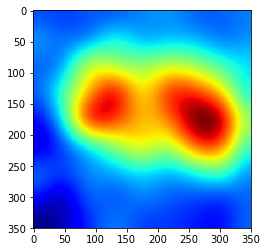

In [221]:
plt.imshow(fmaps, cmap='jet', alpha=1)

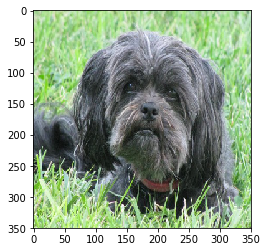

In [218]:
plt.imshow(test_image[0]/255)

## Plots Weights For Each Class

In [ ]:
# Planning to use the weights for each class node in the final output as a vector describing the dog breed.

# Using PCA and t-SNE I would like to try to reduce the vectors down to 3 dimensions and plot them.

# Hopefully similar looking dog breeds will be grouped together.